<center><h1><b><u> Multilayer Perceptron for MNIST Dataset From Scratch</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [1]:
import numpy as np
from operator import itemgetter
import random
import json
import pickle
import matplotlib.pyplot as plt
from PIL import Image

## __Loading the Data__

In [2]:
def extract_images(filename):
    '''Many file formats use magic numbers so that file readers can easily identify them to verify its reading correct file type. This prevents some errors. Each
    pixel is represented from value 0-255 (an unsigned byte/8 bit integer). Metadata is big endian (>, normal) and 4 byte/32 bit integer and stored as 1D array.
    file.read(x) takes x bytes from the file and creates an immutable buffer (a bytes object, an array of bytes) and stores it in memory. frombuffer interprets buffer object as array
    of bytes of certain data type. It doesn't copy the data just provides a view of the existing data and converts to numpy array.'''
    with open(filename, 'rb') as f: #read binary
        buffer = f.read(16) #metadata
        magic, num_images, rows, cols = np.frombuffer(buffer, dtype='>i4') #rows and columns per image (dimensions)
        data = np.frombuffer(f.read(), dtype=np.uint8) #read and store remaining data in 1D numpy array; #numpy spaces out elements instead of commas
        data = data.reshape(num_images, rows, cols).astype(np.float32) #reshape flat data into 3D, num_image amt of rows x cols arrays
    return data

def extract_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = np.frombuffer(f.read(8), dtype='>i4')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels] #certain row of the identity matrix

def load_mnist():
    data_path = '../data/MNIST/raw'
    train_images = extract_images(f'{data_path}/train-images-idx3-ubyte')
    train_labels = extract_labels(f'{data_path}/train-labels-idx1-ubyte')
    test_images = extract_images(f'{data_path}/t10k-images-idx3-ubyte')
    test_labels = extract_labels(f'{data_path}/t10k-labels-idx1-ubyte')

    #Make sure data is right shape for forward pass
    train_images_flat = train_images.reshape(60000, 784).T
    test_images_flat = test_images.reshape(10000, 784).T

    train_labels_one_hot = one_hot_encode(train_labels).T
    test_labels_one_hot = one_hot_encode(test_labels).T
    
    return (train_images_flat, train_labels_one_hot), (test_images_flat, test_labels_one_hot) #each dataset is tuple of numpy arrays

In [3]:
#Comma means tuple containing 1 element otherwise would just be int; numpy arrays come with useful attributes like shape
(train_images, train_labels), (test_images, test_labels) = load_mnist()

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (784, 60000)
Train labels shape: (10, 60000)
Test images shape: (784, 10000)
Test labels shape: (10, 10000)


## __Viewing a Sample__

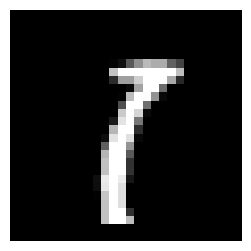

In [4]:
index = random.randrange(0, train_images.shape[1])

plt.figure(figsize=(6, 3))
plt.imshow(train_images[:, index].reshape(28,28), cmap = 'gray')
plt.axis("off")
plt.show()

## __Initializing the Hyperparameters__

In [5]:
class Hypers:
    def __init__(self, hyperpath):
        with open(hyperpath, 'r') as file:
            hyper_dict = json.load(file)
        self.lr = hyper_dict['learning_rate']
        self.b_size = hyper_dict['batch_size']
        self.n_slope = hyper_dict['n_slope']
        self.epochs = hyper_dict['epochs']
        self.hidden = hyper_dict['hidden']


#can feed this into functions that need hypers
hypers = Hypers('../config/mlp-scratch-hyperparameters.json')

## __Defining Functions__

### __Activations__

In [6]:
def softmax(x): #x is vector
    # Subtract max for numerical stability, keeping dims for proper broadcasting
    x_shifted = x - np.max(x, axis=0, keepdims=True)
    
    # Compute exponentials
    exp_x = np.exp(x_shifted)
    
    # Compute softmax
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

In [7]:
def relu(z):
    return np.maximum(z, 0)

In [8]:
def drelu_dz(z):
    return np.where(z <= 0, 0.0, 1.0).astype(np.float32)

### __Parameter Initialization__

In [9]:
def he_init(shape):
    #output, input
    fan_out, fan_in = shape
    
    #scaling factor; 2 for ReLU
    scaling = np.sqrt(2/fan_in)

    #create matrix sampled from Gaussian and multiply by scaling factor
    return np.random.randn(fan_out, fan_in) * scaling

### __Outlining the Model__

In [10]:
class Optimizer:
    def __init__(self, batch_size = 64, learning_rate = 0.01):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
    
    def step(self, W1, dW1, b1, db1, W2, dW2, b2, db2):
        #Don't actually have a gradient vector; this subtraction acts as taking step in direction of gradient
        W1 = W1 - self.learning_rate*dW1
        b1 = b1 - self.learning_rate*db1

        W2 = W2 - self.learning_rate*dW2
        b2 = b2 - self.learning_rate*db2

In [11]:
class MultiLayerPerceptron:
    def __init__(self, input_dim = 784, hidden_dim = 1024, output_dim = 10):
        optimizer = Optimizer()
        
        #Input to hidden
        self.W1 = he_init((hidden_dim, input_dim)) #can also do X @WT
        self.b1 = he_init((hidden_dim, 1)) #add this same bias vector to all z vectors across batches

        #hidden to output
        self.W2 = he_init((output_dim, hidden_dim))
        self.b2 = he_init((output_dim, 1)) #add this same bias vector to all z vectors across batches
        
    #forward
    def __call__(self, X, y_truth):
        #input to hidden
        Z1 = self.W1 @ X + self.b1 #Z - feature_dim x batch_size
        A1 = relu(Z1)

        #Hidden to output
        Z2 = self.W2 @ A1 + self.b2

        #Calculate loss
        loss = softmax(Z2, y_truth)



### __Initialize Parameters__

In [12]:
def initialize_param(input_dim, hidden_dim, output_dim):
    #Input to hidden
    W1 = he_init((hidden_dim, input_dim))
    b1 = he_init((hidden_dim, 1))

    #Hidden to output
    W2 = he_init((output_dim, hidden_dim))
    b2 = he_init((output_dim, 1))

    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    return parameters

### __Forward Propogation__

In [13]:
def forward(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = (W1 @ X) + b1
    A1 = relu(Z1)

    Z2 = (W2 @ A1) + b2
    A2 = softmax(Z2)

    forward_matrices = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

    return forward_matrices

In [14]:
def average_loss(A2, Y):
    m = Y.shape[1]
    # Use maximum of A2 and epsilon
    epsilon=1e-15
    A2_safe = np.maximum(A2, epsilon)

    #same as doing (1/m) * sum of all columns (sum of values in a column of Y * np.log(A2_safe)); (1/m) total loss across whole batch
    return (-1/m) * np.sum(Y * np.log(A2_safe)) 

### __Backpropogation__

In [15]:
def back_prop(X, Y, parameters, forward_matrices):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = forward_matrices['Z1']
    A1 = forward_matrices['A1']
    Z2 = forward_matrices['Z2']
    A2 = forward_matrices['A2']

    m = X.shape[1] #batch size

    dZ2 = (A2 - Y)
    dW2 = (1/m)*(dZ2 @ A1.T)
    db2 = (1/m)*np.sum(dZ2, axis = 1, keepdims = True) #sums across each row (column sum)

    dZ1 = (W2.T @ dZ2)*drelu_dz(Z1) 
    dW1 = (1/m)*(dZ1 @ X.T)
    db1 = (1/m)*np.sum(dZ1, axis = 1, keepdims = True)

    gradients = {'dW1': dW1, 'db1': db1, 'dW2' : dW2, 'db2': db2}

    return gradients

### __Gradient Descent__

In [16]:
def step(parameters, gradients, lr):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = gradients['dW1']
    db1 = gradients['db1']
    dW2 = gradients['dW2']
    db2 = gradients['db2']
    
    W1 = W1 - lr*dW1
    b1 = b1 - lr*db1
    W2 = W2 - lr*dW2
    b2 = b2 - lr*db2

    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    return parameters

In [17]:
def model(X, Y, hidden_dim, lr, epochs):
    input_dim = X.shape[0]
    output_dim = Y.shape[0]

    parameters = initialize_param(input_dim, hidden_dim, output_dim)

    avg_losses = []

    for i in range(epochs):
        forward_matrices = forward(X, parameters)
        avg_loss = average_loss(forward_matrices['A2'], Y)
        derivatives = back_prop(X, Y, parameters, forward_matrices)
        parameters = step(parameters, derivatives, lr)

        avg_losses.append(avg_loss)

        if ((i+1)%10 == 0):
            print(f'Loss after {i + 1} epochs is {avg_loss}')
    
    return parameters, avg_losses

In [28]:
parameters, avg_losses = model(train_images, train_labels, hypers.hidden, lr = hypers.lr, epochs = hypers.epochs)

Loss after 10 epochs is 16.475786189548238
Loss after 20 epochs is 1.7081419502931097
Loss after 30 epochs is 1.2858462600828626
Loss after 40 epochs is 1.0784591382860431
Loss after 50 epochs is 0.8921145618753229
Loss after 60 epochs is 0.8235217323631893
Loss after 70 epochs is 0.7104000563992294
Loss after 80 epochs is 0.6807107557723096


### __Pickling the Model__

In [45]:
f_name = "mlp-scratch-91.2.pkl"

In [20]:
#Save the model

#with open(f'../models/{f_name}', 'wb') as f:
    #pickle.dump(parameters, f)

In [21]:
# Loading the model
with open(f'../models/{f_name}', 'rb') as f:
    loaded_parameters = pickle.load(f)

### __Evaluating the Model__

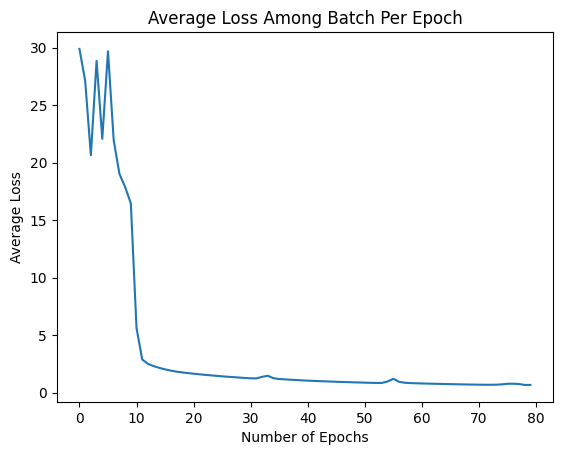

In [46]:
t = np.arange(0, 80)
plt.plot(t, avg_losses)
plt.title("Average Loss Among Batch Per Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel("Average Loss")
plt.show()

In [47]:
def evaluate(images, labels, parameters):    
    forward_matrices = forward(images, parameters)
    probabilities = forward_matrices['A2']

    y_pred = np.argmax(probabilities, 0)
    y_truth = np.argmax(labels, 0)

    acc = np.sum(y_pred == y_truth) / len(y_truth) #same as np.mean
    return acc

In [48]:
train_acc = evaluate(train_images, train_labels, parameters) 
test_acc = evaluate(test_images, test_labels, parameters) 


print(train_acc)
print(test_acc)

0.8401166666666666
0.8332


### __Inference on New Image__

In [49]:
def preprocess(image):
    #Resize and convert to numpy
    image = np.array(image.resize((28, 28)))
    
    im_normalized = image / 255.0
    
    return im_normalized.reshape(784, 1)

In [50]:
image_path = '../data/test-images/6-1.png'
image = Image.open(image_path).convert('L')

#normalize and change to proper dimension
image = preprocess(image)

In [51]:
forward_matrices = forward(image, parameters)
probabilities = forward_matrices['A2']

y_pred = np.argmax(probabilities, axis = 0) #axis numbering starts at outermost dim (columns)
print(y_pred)

[6]
